# Check output of SMICA for residuals, on map and powerspectrum level 

## Header

In [1]:
%%capture
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import matplotlib.gridspec as gridspec
import json
import copy
from astropy.io import fits
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO

from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen as fn_gen
from component_separation.cs_util import Filename_gen_SMICA as fns_gen

import component_separation.powerspectrum as pw
import component_separation.covariance as cv
import matplotlib.pyplot as plt

csu = Config()
io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)

EEBB = 1
Tscale ='K_RJ'

In [2]:
import warnings
warnings.filterwarnings('ignore')

lmax = csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter
colors = csu.CB_color_cycle
bcorr = np.array([
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ])
beam5 = hp.gauss_beam(0.00145444, lmax, pol = True)[:,1]
beam5_binned = hpf.bin_it1D(beam5, bins=bins)

from component_separation.config_planck import BeamfDX12, BeamfNPIPE

beamf_dict = BeamfDX12.get_beamf()
beamfDX12 = io.load_beamf(beamf_dict, csu.freqcomb)

beamf_dict = BeamfNPIPE.get_beamf()
BeamfNPIPE = io.load_beamf(beamf_dict, csu.freqcomb)

In [3]:
Cl_tot = io.load_data(fn.get_spectrum("T", "non-separated"))
covl_tot = cv.build_covmatrices(Cl_tot, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

Cl_N = io.load_data(fn.get_spectrum("N", "non-separated"))
covl_N = cv.build_covmatrices(Cl_N, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

Cl_S = io.load_data(fns.get_spectrum("S", "non-separated"))
covl_S = cv.build_covmatrices(Cl_S, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
for k, v in smica_params.items():
    smica_params[k] = io.load_data(fns.get_misc(k))
    
    
W_smica = io.load_data(fns.get_misc('w'))
W_mv = io.load_data(fn.get_misc('w'))
W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
W_total[:,:,0:2] = 0.0

# CMB_n = io.load_data(io.fh.map_cmb_sc_path_name)
# MV_n = io.load_data(io.fh.cmbmap_smica_path_name)
# smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)

smica_param = dict({'cov': None, "cov4D": None, "CMB": None, "gal": None, "gal_mm": None, "w": None})
for k, v in smica_param.items():
    smica_param[k] = io.load_data(fns.get_misc(k))

loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClT_non-separated_2048_4000_6000_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClN_non-separated_2048_4000_6000_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/Sest/ClS_NPIPEsim.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_cov_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_cov4D_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_CMB_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_gal_mm_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/w_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_cov_SMICA_highell_bins_JC.npy
lo

# Load Maudes DX12 results and compare
Comparison only sensible when data is in $K_{RJ}$ scale

In [4]:
md_N = np.loadtxt("/global/homes/s/sebibel/data/maude/N.txt").reshape(7,37)
md_A = np.loadtxt("/global/homes/s/sebibel/data/maude/A.txt").reshape(7,7)

md_P = np.loadtxt("/global/homes/s/sebibel/data/maude/P.txt").reshape(7,7,37)

md_hR = np.loadtxt("/global/homes/s/sebibel/data/maude/hR_binned_full.txt").reshape(7,7,37)
md_Rl = np.loadtxt("/global/homes/s/sebibel/data/maude/Rl.txt").reshape(7,7,4001)

md_w_raw = np.loadtxt("/global/homes/s/sebibel/data/maude/raw_filter_cmb_full.txt").reshape(2,7,4001)
md_w_mc = np.loadtxt("/global/homes/s/sebibel/data/maude/mc_filter_cmb_full.txt").reshape(2,7,4001)
md_w = np.loadtxt("/global/homes/s/sebibel/data/maude/w_binned_full.txt")

md_bins = np.loadtxt("/global/homes/s/sebibel/data/maude/bins.txt")

## Covariance, md_Rl

(0.001, 1.0)

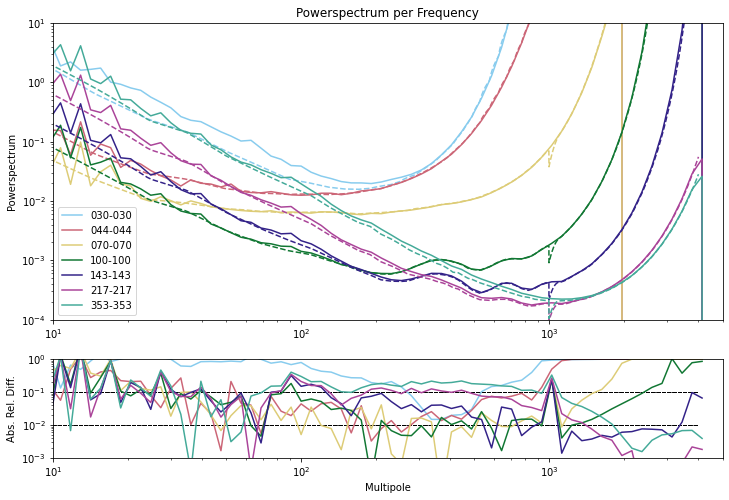

In [5]:
from scipy.signal import savgol_filter as sf
# ax = plt.figure(constrained_layout=True).subplots(2,1, sharex=True)
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
lspc = np.logspace(0,4, 100)
lsbins = lspc[:-1]
rsbins = lspc[1:]
logbins = np.array([[n,m] for n,m in zip(lsbins, rsbins)])
for n in range(0,md_P.shape[0]):
    for m in range(0,md_P.shape[0]):
        if n == m:
            ax0.plot(np.mean(logbins, axis=1), hpf.bin_it1D(covl_tot[EEBB, n,m,:4001]*1e12,bins=logbins), color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
            # ax0.plot(covl_tot[EEBB,n,m,:4001]*1e12, color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
            ax0.plot(md_Rl[n,m,:]*1e6/beam5**2, color=colors[m], ls= '--')
            
            buff = (
                hpf.bin_it1D(covl_tot[EEBB,n,m,:4001]*1e12,bins=logbins)-hpf.bin_it1D(md_Rl[n,m,:]*1e6/beam5**2,bins=logbins)
            )/(
                hpf.bin_it1D(md_Rl[n,m,:]*1e6/beam5**2, bins=logbins)
            )
            ax1.plot(np.mean(logbins, axis=1), np.abs(buff), color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
            ax1.hlines(1e-1,0,4000, color='black', ls = '--', lw=1)
            ax1.hlines(1e-2,0,4000, color='black', ls = '--', lw=1)

ax0.legend()
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlim((1e1,5e3))
ax0.set_ylim((1e-4,1e1))
ax0.set_title('Powerspectrum per Frequency')
ax0.set_ylabel('Powerspectrum')

ax1.set_xlabel('Multipole')
ax1.set_ylabel('Abs. Rel. Diff.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim((1e1,5e3))
ax1.set_ylim((1e-3,1e0))

## Noise

Text(0, 0.5, 'Abs. Rel. Diff.')

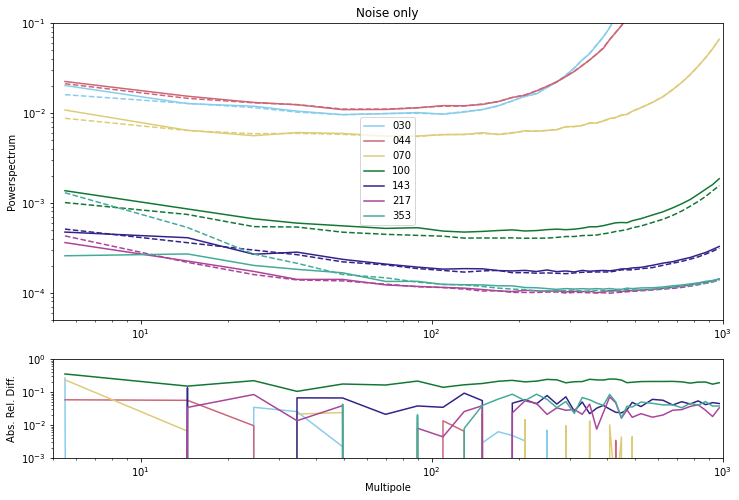

In [6]:
#%matplotlib widget
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for n in range(0,md_N.shape[0]):
    # ax0.plot(covl_N[EEBB,n,n]*1e12, color=colors[n], label="{}".format(csu.PLANCKMAPFREQ[n]))
    averaged = hpf.bin_it1D(covl_N[EEBB,n,n]*1e12,bins=bins)
    ax0.plot(np.mean(bins, axis=1), averaged, color=colors[n], label="{}".format(csu.PLANCKMAPFREQ[n]))
    ax0.plot(np.mean(bins, axis=1), md_N[n]/beam5_binned**2*1e6, color=colors[n], ls='--')
    
    buff = (averaged-md_N[n]/beam5_binned**2*1e6)/(md_N[n]/beam5_binned**2*1e6)
    ax1.plot(np.mean(bins, axis=1), buff,color=colors[n])
    
ax0.set_title('Noise only')
ax0.legend()

ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlim((5,1e3))
ax0.set_ylim((5e-5,1e-1))
ax0.set_ylabel('Powerspectrum')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim((5,1e3))
ax1.set_ylim((1e-3,1e0))
ax1.set_xlabel('Multipole')
ax1.set_ylabel('Abs. Rel. Diff.')

## W_ell hR_ell W_ell^T

In [7]:
lmaxbin = lmax#len(bins)
res_tot_M = np.zeros(shape=(lmaxbin))
res_tot_S = np.zeros(shape=(lmaxbin))
for l in range(lmaxbin):
    res_tot_M[l] = np.dot(np.dot((md_w_mc[0,:,l]*np.diag(beamfDX12[EEBB,:,:,l])/(beam5[l])).T,md_Rl[:,:,l]*1e6/beam5[l]**2),md_w_mc[0,:,l]*np.diag(beamfDX12[EEBB,:,:,l])/(beam5[l]))
    res_tot_S[l] = np.dot(np.dot(W_total[EEBB,:,l].T,covl_tot[EEBB,:,:,l]),W_total[EEBB,:,l])*1e12

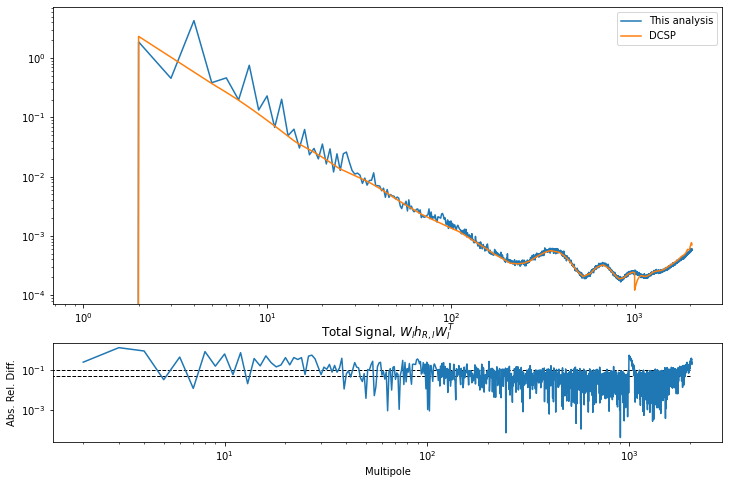

In [8]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.title(r'Total Signal, $W_l h_{R,l} W_l^T$')

ax0.plot(res_tot_S, label = 'This analysis')
ax0.plot(res_tot_M, label = 'DCSP')
# plt.plot(np.mean(bins, axis=1), md_Rs)

buff = (res_tot_M - res_tot_S) / (res_tot_S)
ax1.plot(np.abs(buff))

ax0.legend()
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Multipole')
ax1.set_ylabel('Abs. Rel. Diff.')
ax1.hlines(1e-1,0,2000, color='black', ls='--', lw=1)
ax1.hlines(5e-2,0,2000, color='black', ls='--', lw=1)

In [9]:
bf_binned = np.array([hpf.bin_it1D(beamfDX12[1,n,n,:], bins=bins) for n in range(beamfDX12.shape[1])])
lmaxbin = lmax
md_Rs = np.zeros(shape=(37))
md_Ps = md_P[0,0,:]
md_As = md_A[:,0] 

for l in range(0,37):
    md_Rs[l] = np.dot(md_As* bf_binned[:,l]/beam5_binned[l],md_As*bf_binned[:,l]/beam5_binned[l]) * md_Ps[l] *1e6/beam5_binned[l]**2

## W_ell N_ell W_ell^T

In [10]:
lmaxbin = lmax#len(bins)
res_N_M = np.zeros(shape=(37))
res_N_S = np.zeros(shape=(lmaxbin))
cov_md_N = np.zeros(shape = (7,7,37))
md_w_mc_binned = np.zeros(shape=(7,37))
bf_binned = np.array([hpf.bin_it1D(beamfDX12[1,n,n,:], bins=bins) for n in range(beamfDX12.shape[1])])

for n in range(md_w_mc_binned.shape[0]):
    md_w_mc_binned[n] = hpf.bin_it1D(md_w_mc[0,n,:], bins=bins) #*bcorr[n]/(beam5)
for l in range(37):
    np.fill_diagonal(cov_md_N[:,:,l], md_N[:,l])
for l in range(37):
    res_N_M[l] = np.dot(np.dot((md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l]).T,cov_md_N[:,:,l]*1e6/beam5_binned[l]**2),md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l])

for l in range(lmaxbin):
    res_N_S[l] = np.dot(np.dot(W_total[1,:,l].T,covl_N[EEBB,:,:,l]*1e12),W_total[1,:,l])

Text(0.5, 0, 'Multipole')

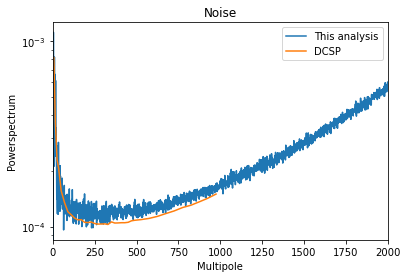

In [11]:
#%matplotlib widget
plt.plot(res_N_S, label='This analysis')
plt.plot(np.mean(bins, axis=1), res_N_M, label='DCSP')
plt.yscale('log')
plt.title('Noise')
plt.xlim((0,2000))
plt.legend()
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')

## W_ell Rg_ell W_ell^T

In [12]:
lmaxbin = lmax
md_Rg = np.zeros(shape=(7,7,37))
cov_gal = np.zeros(shape=(7,7,len(bins)))
for l in range(37):
    cov_gal[:,:,l] = smica_param['gal_mm'][EEBB-1] @ smica_param['gal'][EEBB-1,:,:,l] @ smica_param['gal_mm'][EEBB-1].T

md_Pg = md_P[1:,1:,:]
md_Ag = md_A[:,1:] 
print(md_Ag.shape, md_Pg.shape)
for l in range(0,37):
    md_Rg[:,:,l] = md_Ag @ md_Pg[:,:,l] @ md_Ag.T

(7, 6) (6, 6, 37)


Text(0.5, 0, 'Mutlipole')

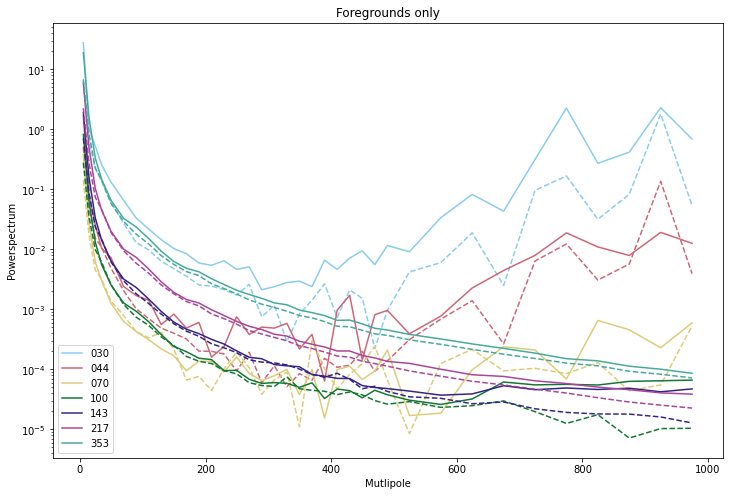

In [13]:
plt.figure(figsize=(12,8))
import component_separation.spherelib.python.spherelib.astro as slhpastro
cov_gal_fac = np.zeros_like(cov_gal)
for n in range(7):
    factor = slhpastro.convfact(freq=int(csu.PLANCKMAPFREQ[n])*1e9, fr='K_CMB',to=Tscale)
    cov_gal_fac[n,n] = cov_gal[n,n]*1e12*factor**2
for n in range(7):
    plt.plot(np.mean(bins, axis=1), cov_gal_fac[n,n,:], color=colors[n], label=csu.PLANCKMAPFREQ[n])
    plt.plot(np.mean(bins, axis=1), md_Rg[n,n,:]*1e6/beam5_binned**2, color=colors[n], ls = '--')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.title('Foregrounds only')
plt.ylabel('Powerspectrum')
plt.xlabel('Mutlipole')

In [14]:
res_G_M = np.zeros(shape=(37))
res_G_S = np.zeros(shape=len(bins))
md_Rg_buf = np.zeros_like(md_Rg)

for n in range(7):
    md_Rg_buf[n,n,:] = md_Rg[n,n,:]*1e6/beam5_binned**2
for l in range(37):
    res_G_S[l] = np.dot(np.dot(W_smica[1,:,l].T,cov_gal_fac[:,:,l]),W_smica[1,:,l])
    # res_G_S[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg_buf[:,:,l]),W_smica[1,:,l])

md_w_mc_beamed = np.zeros(shape=(7,4001))
for l in range(0,4001):
    for n in range(0,7):
        md_w_mc_beamed[n,l] = md_w_mc[0,n,l] * bcorr[n,l]/beam5[l]
md_w_mc_beamed_bnd = np.zeros(shape=(7,37))
for n in range(0,7):
    md_w_mc_beamed_bnd[n] = hpf.bin_it1D(md_w_mc_beamed[n], bins=bins)
for l in range(37):
    res_G_M[l] = np.dot(np.dot(md_w_mc_beamed_bnd[:,l].T,md_Rg_buf[:,:,l]),md_w_mc_beamed_bnd[:,l])
#     res_G_M[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg[:,:,l]*1e6/beam5_binned[l]**2),W_smica[1,:,l])
#     res_G_M[l] = np.dot(np.dot(md_w_mc_beamed[:,l].T,md_Rg[:,:,l]*1e6),md_w_mc_beamed[:,l])

Text(0.5, 1.0, 'Residual Foreground, $W_l R_{g,l} W_l^T$')

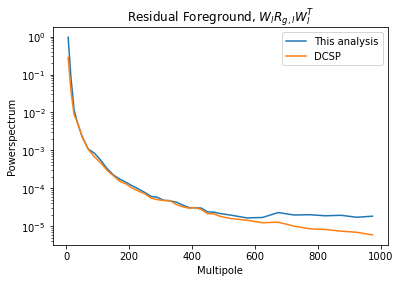

In [15]:
#%matplotlib widget
# for n in range(7):
#     plt.plot(cov_gal[n,n])
plt.plot(np.mean(bins, axis=1), res_G_S, label='This analysis')
plt.plot(np.mean(bins, axis=1), res_G_M, label='DCSP')
plt.title('Residual foreground')
plt.legend()
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')
plt.yscale('log')
plt.title(r'Residual Foreground, $W_l R_{g,l} W_l^T$')

## Weights

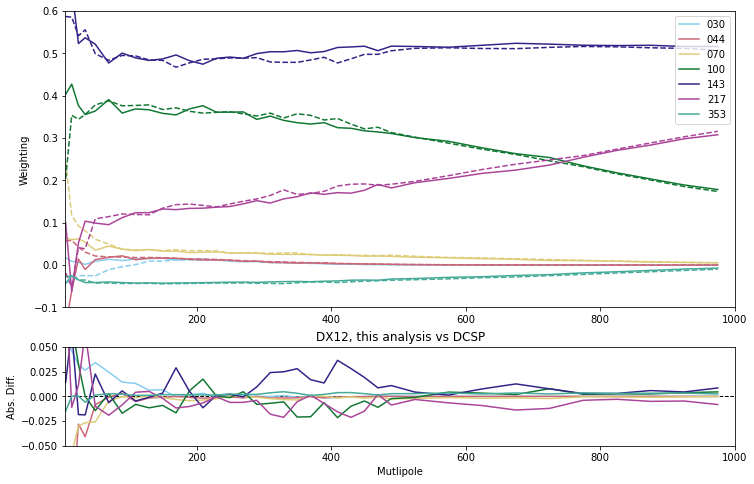

In [16]:
%matplotlib inline
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
W_smica.shape
for n in range(7):
    ax0.plot(np.mean(bins, axis=1), W_smica[1,n,:], color= colors[n],label=csu.PLANCKMAPFREQ[n])
    ax0.plot(np.mean(bins, axis=1), md_w_mc_beamed_bnd[n,:], color= colors[n], ls = '--')
    buff = ( W_smica[1,n,:] - md_w_mc_beamed_bnd[n,:] )
    ax1.plot(np.mean(bins, axis=1), buff, color=colors[n])
ax0.legend()
ax0.set_ylim((-0.1,0.6))
ax0.set_xlim((5,1e3))
plt.title('DX12, this analysis vs DCSP')
ax1.set_ylabel('Abs. Diff.')
ax1.set_xlabel('Mutlipole')
ax0.set_ylabel('Weighting')
ax1.set_ylim((-0.05,0.05))
ax1.set_xlim((5,1e3))
ax1.hlines(0,0,1000, color='black', ls='--', lw=1)

## Signal

(10, 1000.0)

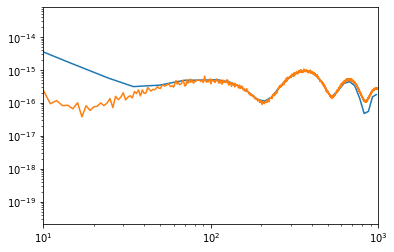

In [17]:
plt.plot(np.mean(bins, axis=1), smica_param['CMB'][0])
plt.plot(Cl_S[0,1])
plt.xscale('log')
plt.yscale('log')
plt.xlim((10,1e3))
# plt.ylim((1e-17,1e-14))

# All Residuals in one plot

## Mine
The following plot is only consistent when data is in $K_{CMB}$ scale

Text(0, 0.5, 'Powerspectrum')

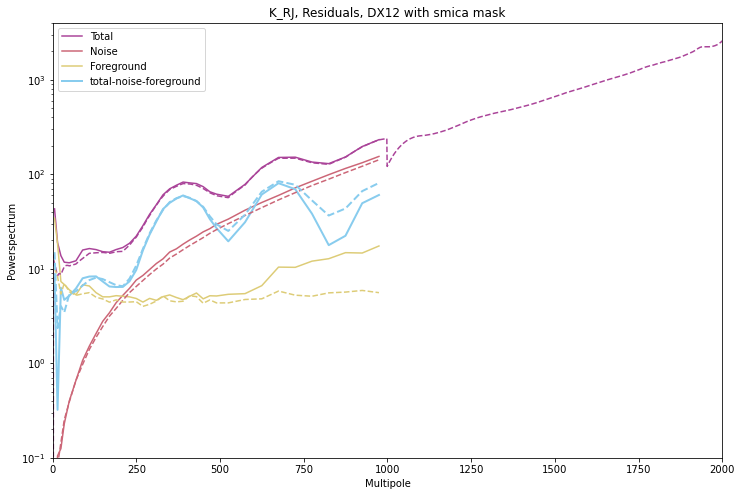

In [19]:
plt.figure(figsize=(12,8))
#%matplotlib widget
def ll(l):
    return (l*(l+1))
bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))

# plt.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_tot_S, bins=bins)*md_w*1e-5*bin_ell, label='Total', color = colors[5])
# plt.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_N_S, bins=bins)*md_w*1e-5*bin_ell, label='Noise', color = colors[1])
# plt.plot(np.mean(bins, axis=1), res_G_S*md_w*1e-5*bin_ell, label='Foreground', color = colors[2])
# plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S)*bin_ell*1e-5*md_w, label='total-noise-foreground', color = colors[0], lw = 2)

plt.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_tot_S, bins=bins)*bin_ell, label='Total', color = colors[5])
plt.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_N_S, bins=bins)*bin_ell, label='Noise', color = colors[1])
plt.plot(np.mean(bins, axis=1), res_G_S*bin_ell, label='Foreground', color = colors[2])
plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S)*bin_ell, label='total-noise-foreground', color = colors[0], lw = 2)

plt.plot(res_tot_M*all_ell, color = colors[5], ls = '--')
plt.plot(np.mean(bins, axis=1), res_N_M*bin_ell, color = colors[1], ls = '--')
plt.plot(np.mean(bins, axis=1), res_G_M*bin_ell, color = colors[2], ls = '--')
plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_M, bins=bins)-res_N_M-res_G_M)*bin_ell, color = colors[0], lw = 2, ls = '--')


# plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0]*bin_ell, label='SMICA best fit', color = colors[3], ls = '--')
# plt.plot(np.mean(bins, axis=1), hpf.bin_it1D(Cl_S[0,1,:4000],bins=bins)*1e12*md_w*bin_ell*1e-5, label='Planck best fit', color = colors[3], alpha=0.8, lw = 1)
# plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0]*bin_ell, color= 'black', lw=1, label='SMICA best fit')

plt.yscale('log')
plt.ylim((1e-1,4e3))
plt.xlim((0,2000))
plt.title('{}, Residuals, {} with {} mask'.format(Tscale, csu.freqdset, csu.mskset))
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

## Maude TBD
Maudes data is D_l in K_RJ scale

Text(0, 0.5, 'Powerspectrum')

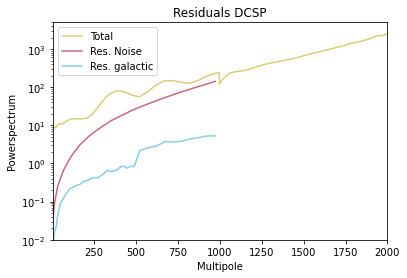

In [20]:
%matplotlib inline
def ll(l):
    return (l*(l+1))

bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))
plt.plot(res_tot_M*all_ell, label='Total', color = colors[2])
plt.plot(np.mean(bins, axis=1), res_N_M*bin_ell, label='Res. Noise', color = colors[1])
plt.plot(np.mean(bins, axis=1), res_G_M*md_w*1e-5*bin_ell, label='Res. galactic', color = colors[0])

plt.yscale('log')
plt.ylim((1e-2,5e3))
plt.xlim((5,2000))
plt.title('Residuals DCSP')
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

# Compare weights (DX12 smica only)
W_smica = io.load_data(io.fh.weight_smica_path_name)
 * "- raw_filter_cmb_full.txt: weights derived from the fit (A^T R-1 A)^-1 A^T R^-1"
 * md_w_mc looks familiar
 * md_w = what is that?

(2, 7, 4001)
(2, 7, 4001)
(37,)


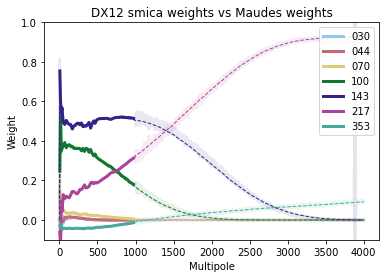

In [21]:
%matplotlib inline
print(md_w_raw.shape)
print(md_w_mc.shape)
print(md_w.shape)
for freq in range(md_P.shape[0]):
    plt.plot(np.mean(bins, axis=1), W_smica[0,freq,:], color=colors[freq], label=csu.PLANCKMAPFREQ[freq], lw=3)
    plt.plot(W_total[1,freq,:], color=colors[freq], lw=3, alpha=0.1)
    plt.plot(md_w_mc[0,freq,:]*bcorr[freq]/(beam5), color=colors[freq], lw=1, ls='--')

plt.title('DX12 smica weights vs Maudes weights')
plt.ylabel('Weight')
plt.xlabel('Multipole')
plt.legend(loc='upper right')
plt.ylim((-0.1,1.0))
plt.show()

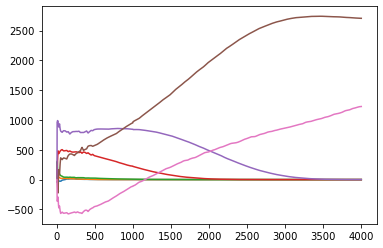

In [23]:
%matplotlib inline
for n in range(0,7):
    plt.plot(md_w_raw[0,n])

----------------------------------------------
# Other

## Derive Maudes weights etc.
md_R = md_hR = md_Rl[:1000]

BUT why are 217 and 353 constant for high ell?

In [25]:
md_fg = np.zeros(shape=(7,7,37))
md_R = np.zeros(shape=(7,7,37))
AP = np.zeros(shape=(7,7,37))
for l in range(0,37):
    AP[1,:,l] = np.dot(md_A, md_P[:,:,l])
    md_fg[:,:,l] = np.dot(AP[:,:,l], md_A.T)
for l in range(0,37):
    for n in range(0,7):
        md_R[n,n,l] = md_fg[n,n,l]# + md_N[n,l]

ValueError: could not broadcast input array from shape (7,7) into shape (7)

In [9]:
%matplotlib inline
for n in range(7):
    plt.plot(np.mean(bins, axis=1), md_R[n,n,:], color=colors[n],label = csu.PLANCKMAPFREQ[n])
#     plt.plot(md_Rl[n,n,:], color=colors[n], ls= '--')
#     plt.plot(np.mean(bins, axis=1), md_hR[n,n,:])
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.legend()
plt.xlabel('Multipole')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Multipole')

## w_binned_full.txt

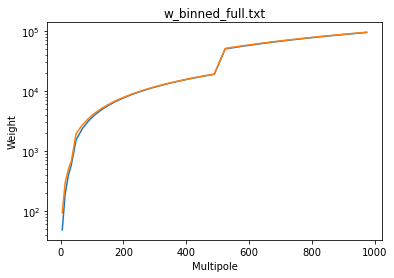

In [129]:
%matplotlib inline
plt.plot(np.mean(bins, axis=1), md_w)
plt.title('w_binned_full.txt')
plt.yscale('log')
plt.ylabel('Weight')
plt.xlabel('Multipole')

plt.plot(np.mean(binshl, axis=1), nmodes_smicahl)
# plt.plot(np.mean(binshl, axis=1), nmodes_lenshl)
# plt.plot(np.mean(binsll, axis=1), nmodes_smicall)
# plt.plot(np.mean(binsll, axis=1), nmodes_lensll)

## raw_filter_cmb_full

In [13]:
%matplotlib widget
for n in range(md_P.shape[0]):
    plt.plot(md_w_raw[0,n,:], label = csu.PLANCKMAPFREQ[n], color=colors[n])
plt.legend()
plt.title('raw_filter_cmb_full.txt')
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### (A^T R-1 A)^-1 A^T R^-1 = 'raw_filter_cmb_full.txt'
 * R here is md_R or md_Rl, the later for large ell
 * A here is sed

In [11]:
print(TSCALE)
TSCALE = "K_RJ"
w = np.zeros(shape=(7,4001))
a = np.ones(shape=(7))
import component_separation.transform_map as trsf_m
a = np.array([trsf_m.tcmb2trj_sc(FREQ, fr=r'K_CMB', to=TSCALE) for FREQ in csu.PLANCKMAPFREQ_f])
# a = md_A
for l in range(0,4001):
    denom = 1/(a.T @ np.linalg.inv(md_Rl[:,:,l]) @ a)
    nom = a.T @ np.linalg.inv(md_Rl[:,:,l])
    w[:,l] = np.dot(denom, nom)

K_CMB


BUT: only when multiplied by *1e-3

In [12]:
%matplotlib widget
for n in range(7):
    plt.plot(w[n], color=colors[n], label = csu.PLANCKMAPFREQ[n], alpha=0.5)
    plt.plot(md_w_raw[0,n,:]*1e-3, color=colors[n], ls = '--', lw = 1)
plt.legend()
plt.title('filters / weights')
plt.ylabel('Weight')
plt.xlabel('Multipole')
plt.yscale('log')
plt.xlim((100,4e3))
# plt.ylim((1e-6,1e0))
# plt.xscale('log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(100.0, 4000.0)